In [13]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

# Project 1: The Power of Data

In this project, I will use table manipulations and visualizations to help biologists determine which specific cells in our lungs are associated with the disease cystic fibrosis.

In the past few decades, new computational, mathematical and scientific innovations have contributed to an exponential increase in the volume, variety and velocity of data generation.

Among the countless scientific fields embracing 'big data', biological sciences presents an impressive avenue for leveraging data science.

In the following project I will use data science to understand a large quantity of data, across many variables, and single out a future avenue for biological research on cystic fibrosis.

### Basic Biology Overview

1. All living things are made up of cells.
2. All cells in an organism share the same genetic code called "DNA", the molecular instructions for all functions of living things. The molecules that encode our DNA are called "Base Pairs".
3. Cells are different because they implement different parts of the DNA at different times. DNA is actually implemented—"expressed"— in the cell when parts of it are converted to "RNA". Sections of RNA are then converted to proteins.
4. Sections of DNA are called "Genes". Genes are portions of DNA that we have identified as coding for specific proteins: molecules that have some function in the body. For example, the protein hemoglobin carries oxygen in your blood.

**So as a summary:**

$$\text{DNA} \rightarrow \text{RNA} \rightarrow \text{Protein} \rightarrow \text{Function}$$

# 1. New Technology

### In this section of the project we will learn about a new technology that has increased the power of biological analysis. We will first assess how popular this technology is.

The amount of data governing living organisms is staggering.

While the [Human Genome Project](https://en.wikipedia.org/wiki/Human_Genome_Project) successfully sequenced the 3+ billion base pairs that compose human DNA in 2003, knowing our genetic code does not tell us how it is actually implemented and interpreted in our bodies. 

Every cell in your body has the same DNA<sup>1</sup>, but a neuron cell in your brain looks and behaves very differently from a stomach cell, a skin cell, a white blood cell or a cell in your lungs.

*$ ^{1}$Individual cells may have a tiny amount of variation due to mutation.*

[**Brain Cells**](https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/Human_astrocyte.png/1200px-Human_astrocyte.png)
![Brain Cells](brain_cells.png)

[**Stomach Cells**](https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Chief_cells.JPG/1200px-Chief_cells.JPG)
![Stomach Cells](stomach_cells.jpg)

In 2009, biologists began developing new techniques to analyze how our genome is actually expressed in individual cells. These new techniques enable scientists to better understand complex biological phenomena at unprecedented resolutions. 

One of these technologies is called "Single Cell RNA Sequencing" (scRNA-seq).

**By investigating RNA expression in individual cells, we can better understand how cells are actually functioning and where certain diseases may arise.**

If you are interested in a little bit more info about this technology, you can watch the following video, but it's not necessary for the completion of the project:

In [14]:
from IPython.display import HTML
HTML('''
<iframe width="600" height="480" src="https://www.youtube.com/embed/DWcFTjrEBDg" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen>
</iframe>
''')

Let's take a look at the popularity of this technology over the past few years.

**A really useful research tool for determining popularity is [Google Trends](https://trends.google.com/trends/).**

Google Trends lets you compare the popularity of search terms on Google.


In [15]:
# Load in the following data
sc = Table.read_table("single_cell_sequencing_pop.csv").relabeled(1, "Interest over time")
sc.show(20)

Month,Interest over time
2004-01,0
2004-02,0
2004-03,0
2004-04,0
2004-05,30
2004-06,0
2004-07,0
2004-08,0
2004-09,0
2004-10,0


The `sc` table contains the `Interest over time` for the search topic "Single Cell Sequencing", worldwide, broken down by `month`. Google trends defines Interest over time as:

> Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means there was not enough data for this term.

**Dataset Details:**
- Origin: The dataset can be found [here](https://trends.google.com/trends/explore?date=all&q=%2Fm%2F0_t__77) **[We've already downloaded it for you]**
- Extra Context: Google is not the predominant search engine in every country. Google may not be the primary tool used for scientific research. We're not sure of the accuracy of these reports.

The first month in the data set is January 2004. In order to visualize this data, we need to convert the month column to floats. Add a column called `Time` to the `sc` table with a decimal representation of the month. 

For example, the first month in the dataset, January 2004, should be represented as `2004.0`, the fifth month in the dataset should be `2004.3333` and the thirteenth month in the dataset should be `2005`.

In [16]:
# HINT: Try to use array arithmetic
# HINT: How long should the array you add to the table be?
# The sc table has one row for every month in the time frame... 
# how can you access the number of months?
month_floats = 2004 + np.arange(0, sc.num_rows) / 12
month_floats
sc = sc.with_column("Time", month_floats)
sc

Month,Interest over time,Time
2004-01,0,2004
2004-02,0,2004.08
2004-03,0,2004.17
2004-04,0,2004.25
2004-05,30,2004.33
2004-06,0,2004.42
2004-07,0,2004.5
2004-08,0,2004.58
2004-09,0,2004.67
2004-10,0,2004.75


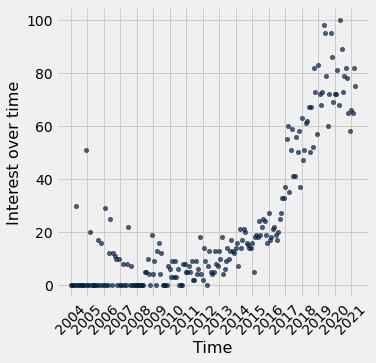

In [17]:
#Visualize the popularity of the search term 'Single Cell Sequencing' over the entire time range.
sc.scatter("Time", "Interest over time")
plots.xticks(np.arange(2004, 2022), rotation = 45); 

In [18]:
#Assign the corresponding string value from the `Month` column to `most_popular`.

twenty_eighteen = sc.where("Time", are.between(2008.0, 2009))
most_popular = twenty_eighteen.sort("Interest over time", descending=True).column("Month").item(0)
most_popular

'2008-12'

Oftentimes when working with data that is associated with times and dates, it is useful to take a "Rolling Average", which reports the value as the average value of the `k` previous points.

If there aren't k values before the value you want the rolling average of, the rolling average value should be 0.

I define the function `rolling_average`, which takes in the integer arguments `i` and `k`, and returns the `k` rolling average of the `Interest over time` values for the `i`th row in the popularity table.

For example, if I want to take the rolling average of the previous k = 3 points for row with index i = 10, which rows do we want to be taking the Interest over time average for? (Rows with index 7, 8 and 9. Note that we do not include the value from the row with index 10).*

**Hint: The following picture might help visualize this concept:**

<img src="rolling_average.png">

In [20]:
def rolling_avg(i, k):
    '''The k-rolling average for the ith row in the sc table.'''
    if k > i:
        return 0
    k_previous_row_indices = np.arange(k) + i - k
    tbl_k_rows = sc.take(k_previous_row_indices)
    return np.average(tbl_k_rows.column("Interest over time"))

# The k=12 rolling average for month 13
second_rolling_average = rolling_avg(13, 12)
second_rolling_average

6.75

Visualize the rolling average with `k=12` popularity of the search term 'Single Cell Sequencing' over the entire time range.

Month,Interest over time,Time,Rolling Average
2004-01,0,2004,0
2004-02,0,2004.08,0
2004-03,0,2004.17,0
2004-04,0,2004.25,0
2004-05,30,2004.33,0
2004-06,0,2004.42,0
2004-07,0,2004.5,0
2004-08,0,2004.58,0
2004-09,0,2004.67,0
2004-10,0,2004.75,0


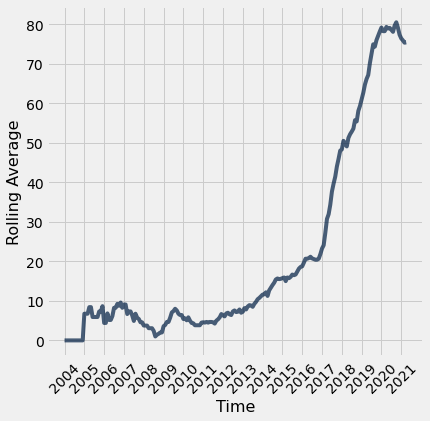

In [21]:
row_numbers = Table().with_columns("i", np.arange(sc.num_rows), "k", 12)

rolling_averages = row_numbers.apply(rolling_average,"i", "k")
sc_rolling_average = sc.with_column("Rolling Average", rolling_averages)
sc_rolling_average.plot("Time", "Rolling Average")


plots.xticks(np.arange(2004, 2022), rotation = 45); 
sc_rolling_average

The graph demonstrates a somewhat slow and steady rise in popularity between mid-2013 and 2016, followed by a big boom of popularity between 2017 and 2020, peaking in the last quarter of 2020. The dip at the end of 2020 does not mean that fewer people are using the technology, it simply means that there was a reduction in frequency of how much people look up the term.


# 2. Single Cell RNA Sequencing Data

### Now that you have learned a bit about this new technology, I'm going to use real Single Cell RNA Sequencing (scRNA-seq) data to investigate cystic fibrosis.

This section of the project and section 3 are based on the paper [A revised airway epithelial hierarchy includes CFTR-expressing ionocytes](https://pubmed.ncbi.nlm.nih.gov/30069044/) and corresponding [data](https://singlecell.broadinstitute.org/single_cell/study/SCP163/airway-epithelium#study-summary).

>"The airways of the lung are the primary sites of disease in asthma and cystic fibrosis." (Montoro et al)

Many diseases impact the function of the cells in our lungs, including cystic fibrosis.

>"Cystic fibrosis (CF) is a genetic disorder that affects mostly the lungs, but also the pancreas, liver, kidneys, and intestine. Long-term issues include difficulty breathing and coughing up mucus as a result of frequent lung infections." [Wikipedia](https://en.wikipedia.org/wiki/Cystic_fibrosis)

Using Single Cell Sequencing and data science, biologists in the paper were able to identify a small subset of lung cells that appear to be the primary instigators of cystic fibrosis. By identifying these cells, scientists will be able to target drugs to cure cystic fibrosis with more accuracy. 

**I will work to identify these same cells**

### Data Format

Single Cell RNA Sequencing (scRNA-seq) data is generally stored in a special data-saving format called the "Market Exchange Format" (MEX).

scRNA-seq experiments collect a gene RNA expression value for every single cell, and every gene, in a sample of tissue. Since gene RNA expression values are 0 for many gene-cell pairs, the MEX format does not store these values.

Let's take a look at the data from the study. The biologists analyzed 7193 mouse cells.

The following cells read in the `matrix`, `cells` and `genes` tables.

**Dataset Details:**
- Origin: This dataset was sourced from [here](https://singlecell.broadinstitute.org/single_cell/study/SCP163/airway-epithelium#study-summary). **Not required:** To access the data, you can login with a google account. To replicate the expression data, you can download the required files listed in data_gen.ipynb and data_gen_2.ipynb. **[You don't have to do this, we've already done it for you]**
- Extra Context: There is no other context for this data.

In [22]:
matrix = Table.read_table("matrix.csv")
cells = Table.read_table("cells.csv")
genes = Table.read_table("genes.csv")

The `matrix` table contains one row **for each pair of Gene and Cell that had an RNA expression above 0**. Instead of using the names of the genes and cells, the `matrix` table instead refers to them by their numbers, stored in the `Gene Number` and `Cell Number` columns.

In [23]:
matrix

Gene Number,Cell Number,Expression
9,2,1.07
8,5,0.8
8,8,0.81
8,10,3.81
9,10,2.42
8,11,1.35
9,12,1.38
8,13,0.72
9,14,0.74
9,18,1.68


In [24]:
cells

Cell Name,Cell Number
WT_M1_GCTTGAGAAGTCGT,1
WT_M1_GGAACACTTTCGTT,2
WT_M1_GGAATGCTTCGACA,3
WT_M1_GGACAACTCTGAGT,4
WT_M1_GGACAACTTCGCTC,5
WT_M1_GGACATTGTCTGGA,6
WT_M1_GGACCCGAAGAGTA,7
WT_M1_GGACCTCTGGTTCA,8
WT_M1_GGACTATGCGCCTT,9
WT_M1_GGAGCAGATGGAGG,10


In [25]:
genes

Gene Name,Gene Number
P2ry14,1
Atp6v0d2,2
Stap1,3
Cftr,4
Ascl3,5
Moxd1,6
Foxi1,7
Asgr1,8
Atp6v1c2,9


I assign `num_obs` to the number of possible cell and gene pairs in the experiment. A cell and gene pair is known as an observation (I make sure to count RNA expression values that are equal to 0).

In [26]:
num_obs = genes.num_rows * cells.num_rows
num_obs

64737

Cell Numbers and Gene Numbers can be difficult to work with. So I assign `matrix_with_names` to a copy of the `matrix` table but with the *names* of Cells and Genes instead of numbers. The new table should have the columns `Cell`, `Gene` and `Expression`.


In [29]:
matrix_with_cell_names = matrix.join("Cell Number", cells)
matrix_with_gene_names = matrix_with_cell_names.join("Gene Number", genes)
matrix_with_names = matrix_with_gene_names.drop("Cell Number", "Gene Number").relabel("Cell Name", "Cell").relabel("Gene Name", "Gene")
matrix_with_names

Expression,Cell,Gene
0.82,WT_M1_TACGAGTGAGCCAT,P2ry14
0.46,WT_M1_TTGCATTGACCGAT,P2ry14
1.95,WT_M2_AACTCACTGAACTC,P2ry14
1.8,WT_M2_ACCACCTGAAAGTG,P2ry14
1.53,WT_M2_ACGACAACTGGTGT,P2ry14
1.04,WT_M2_AGCTGTGATATGCG,P2ry14
0.83,WT_M2_AGGTCTGAGCGTTA,P2ry14
0.79,WT_M2_ATACCTACTTACCT,P2ry14
1.57,WT_M2_ATTAGTGAATTCGG,P2ry14
4.24,WT_M2_ATTGCTTGTCTCAT,P2ry14


We use cell and gene numbers instead of names to save space. How many characters in total are used to store the names of cells and the names of genes in all of `matrix_with_names`? I assign that value to `num_chars`.

In [30]:
num_gene_chars = matrix_with_names.column("Gene")
num_cell_chars = matrix_with_names.column("Cell")

char_in_gene = 0
for word in num_gene_chars:
        char_in_gene += len(word)

char_in_cell = 0
for word in num_cell_chars:
        char_in_cell += len(word)


num_chars = char_in_gene + char_in_cell
num_chars

121756

In order to perform more data analysis, it would be helpful to have a table that lists all the pairs of genes and cells, including those where the expression value is 0.

I assign `dense_matrix` to a table that has a column for cell names called `Cell`, and a column for each gene name. Each row should contain the expression values for the corresponding cell if there is any expression, or 0 if there is no expression.

In [31]:
def first_or_zero(arr):
    '''Returns the first value in the array or 0 if the array is empty.'''
    if (len(arr) == 0):
        return 0
    else:
        return arr.item(0)
    
dense_matrix = matrix_with_names.pivot("Gene", "Cell", "Expression", first_or_zero)
dense_matrix

Cell,Ascl3,Asgr1,Atp6v0d2,Atp6v1c2,Cftr,Foxi1,Moxd1,P2ry14,Stap1
Foxj1GFP_M1_AAAGATCTTGCATG,0,0,0,1.63,0,0,0,0,0
Foxj1GFP_M1_AACCGATGAGATCC,0,0,0,1.17,0,0,0,0,0
Foxj1GFP_M1_AACGGTACAACTGC,0,0,0,1.52,0,0,0,0,0
Foxj1GFP_M1_AATAGGGATTCGTT,0,0,0,2.17,0,0,0,0,0
Foxj1GFP_M1_AATCAAACGGCATT,0,0,0,2.46,0,0,0,0,0
Foxj1GFP_M1_AATCCGGAGGTCAT,0,0,0,1.56,0,0,0,0,0
Foxj1GFP_M1_AATCCTACGGTGAG,0,0,0,2.72,0,0,0,0,0
Foxj1GFP_M1_AATCTCTGAACAGA,0,0,0,2.47,0,0,0,0,0
Foxj1GFP_M1_AATGGCTGAGTGTC,0,0,0,1.26,0,0,0,0,0
Foxj1GFP_M1_AATGTCCTAGCACT,0,0,0,1.5,0,0,0,0,0


### Marker Genes

The gene Cftr has been associated with cystic fibrosis. The table `dense_matrix` contains the expression of 8 genes of interest including Cftr. We call these genes "marker genes".

The biologists wanted to study the effect of using genetic engineering to "turn off" the `Foxi1` gene in some of the mice in the study (we'll see why in part 3).

Some of the cells start with the 2-letter prefix "WT". "WT" stands for "Wild type", which indicates that the cells come from mice *that were not genetically engineered*. (Wild type can be thought of as the control group).

First, in only the wild type group (control), we want to understand the association between expression of the genes Cftr and Foxi1. 

*If we looked at the non-wild type group, all the values for `Foxi1` would be 0, since we turned it off in those mice.*

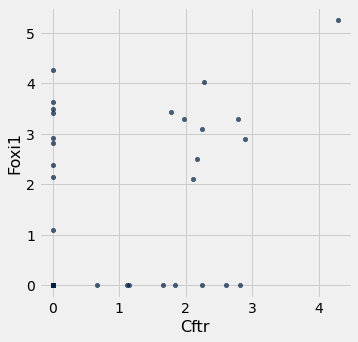

In [34]:
#Next, we visualize the association between expression of the genes `Cftr` and `Foxi1` in cells that start with `"WT"`.

def first_two_letters(string):
    '''Returns the first two characters of a string'''
    return string[0:2]

dense_array = dense_matrix.apply(first_two_letters, "Cell")
dense_table = dense_matrix.with_column("First Two", dense_array).where("First Two", "WT")
#dense_matrix.where("Cell", are.containing("WT")).select("Cftr", "Foxi1")
dense_table.scatter("Cftr", "Foxi1")


We observe a positive association in the expression between these two genes.

### Now that we have successfully loaded in the study data, and started some initial data exploration, we are ready to start investigating the study's findings with regards to cystic fibrosis!

# 3. Cystic Fibrosis

### Now that I have processed the data from the experiment, I can determine which specific cells are associated with cystic fibrosis.

In addition to expression data, the biologists also collected other information about each cell, which will help determine the type of cell associated with cystic fibrosis.

We load in the `tsne` and `metadata` tables.

The `tsne` table contains the `Name` of each cell, and summary numerical values, `X` and `Y`.

The `metadata` table contains more metrics about each cell. 

**In this case, metadata simply means "a set of data that describes and gives information about other data."**

**Dataset Details:**
- Origin: This dataset was sourced from [here](https://singlecell.broadinstitute.org/single_cell/study/SCP163/airway-epithelium#study-summary). **Not required:** To access the data, you can login with a google account. To replicate the expression data, you can download the required files listed in data_gen.ipynb and data_gen_2.ipynb. **[You don't have to do this, we've already done it for you]**
- Extra Context: There is no other context for this data.

In [37]:
tsne = Table.read_table("tsne.tsv", sep="\t")
tsne

NAME,X,Y
WT_M1_GCTTGAGAAGTCGT,33.7013,2.65951
WT_M1_GGAACACTTTCGTT,-9.32879,-35.3672
WT_M1_GGAATGCTTCGACA,4.09252,-30.9445
WT_M1_GGACAACTCTGAGT,2.11504,13.1975
WT_M1_GGACAACTTCGCTC,-7.19801,-34.8209
WT_M1_GGACATTGTCTGGA,23.2688,-10.2378
WT_M1_GGACCCGAAGAGTA,-17.8078,-46.4286
WT_M1_GGACCTCTGGTTCA,-17.0704,-40.0664
WT_M1_GGACTATGCGCCTT,-4.56393,-20.1234
WT_M1_GGAGCAGATGGAGG,6.20114,-55.6744


In [38]:
metadata = Table.read_table("metadata.tsv", sep="\t")
metadata

NAME,cluster,mouse,nGene,Basal_score,Club_score,Ciliated_score
WT_M1_GCTTGAGAAGTCGT,Club,WT_M1,2063,0.375,1.17072,-0.42541
WT_M1_GGAACACTTTCGTT,Club,WT_M1,1571,-1.71258,2.6425,0
WT_M1_GGAATGCTTCGACA,Club,WT_M1,1881,-1.63678,2.73738,0.140587
WT_M1_GGACAACTCTGAGT,Basal,WT_M1,2061,0.645919,0.913838,-0.278481
WT_M1_GGACAACTTCGCTC,Club,WT_M1,2114,-1.70651,2.51677,0.0474835
WT_M1_GGACATTGTCTGGA,Club,WT_M1,1585,-1.39376,1.66843,-0.357173
WT_M1_GGACCCGAAGAGTA,Club,WT_M1,1694,-1.28335,2.72615,-0.0568574
WT_M1_GGACCTCTGGTTCA,Club,WT_M1,2182,-1.51001,2.86138,0.0972027
WT_M1_GGACTATGCGCCTT,Club,WT_M1,2116,-1.5365,1.73065,0.018228
WT_M1_GGAGCAGATGGAGG,Club,WT_M1,1202,-1.99302,3.13552,-0.0332952


### Let's explore the other data the biologists collected.

We can visualize the number of cells of each type in each mouse.

The information about which mouse a cell came from is stored in the `mouse` column of the `metadata` table.

A cell type is one of `"Basal"`, `"Ciliated"`, `"Club"`, `"Goblet"`, `"Ionocyte"`, `"Neuroendocrine"` or `"Tuft"`. This information is stored in the `cluster` column of the `metadata` table. 

There were 6 different mice in the sample. Information about which mouse each cell comes from is stored in the `mouse` column of the `metadata` table.

/opt/conda/lib/python3.9/site-packages/datascience/tables.py:920: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  values = np.array(tuple(values))


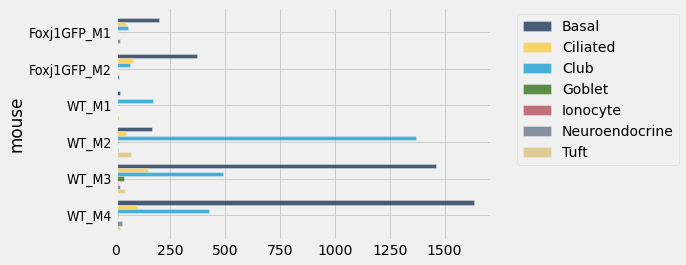

In [39]:
metadata.pivot("cluster", "mouse").barh("mouse")

Visualize the association between the average `Basal_score` and average `Club_score` for each unique `cluster` and `mouse` pair.

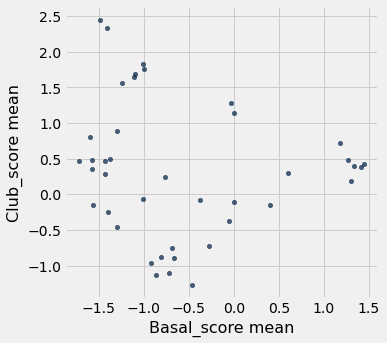

In [40]:
metadata.group(["cluster", "mouse"], np.mean).select("Basal_score mean","Club_score mean").scatter("Basal_score mean", "Club_score mean")

Create a scatter plot of `Y` (as the y axis) vs `X` (as the x axis) for every cell. Color the scatter plot by the `cluster` of the cells.

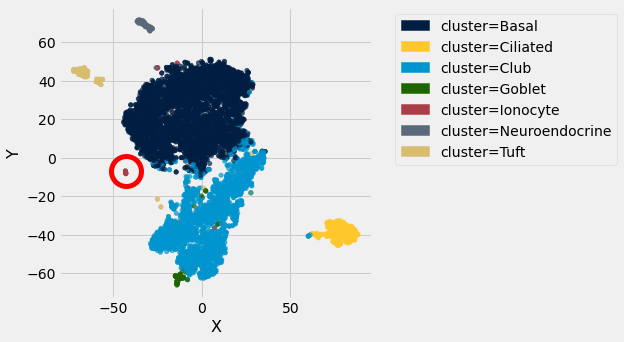

In [42]:
metadata.join("NAME", tsne, "NAME").scatter("X", "Y", group = "cluster")


plots.plot(-43, -7, marker='o', markerfacecolor='None', 
         markeredgecolor='r', markersize=30, markeredgewidth=5, linestyle='none');

#### We marked a specific area of your scatter plot with a large red circle. These few cells (less than 30) were identified as a rare cell type called "Pulmonary Ionocytes".

Recall that the gene Cftr has been associated with cystic fibrosis. The table `dense_matrix`, that you created in part 2, contains expression of 8 genes of interest including Cftr. These are "marker genes". 

I create a table called `proportions` with two columns. The first column is called `cluster` and has one row for each unique value in the `cluster` column of `metadata`. The second column is called `Proportion Cftr > 0` and corresponds to the proportion of cells of that cluster type that have a Cftr expression value above 0.

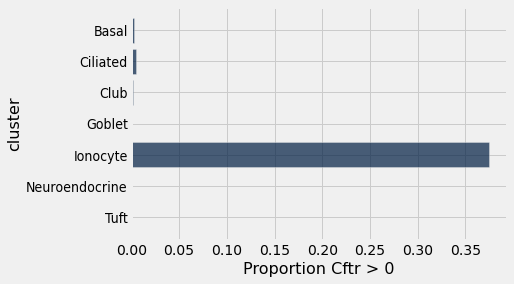

In [44]:
# We need to determine which cells have Cftr greater than 0, 
# and then aggregate that information by cluster!
with_markers = metadata.join("NAME", dense_matrix, "Cell")
with_cftr_above_0 = with_markers.with_column("Above 0", with_markers.column("Cftr")>0)
cluster_and_above_0 = with_cftr_above_0.pivot("Above 0", "cluster")

# To calculate the proportion of cells above 0, we need the number above 0 and the total number of cells!
# num_true_per_cluster and num_per_cluster should be arrays.
num_true_per_cluster = cluster_and_above_0.column("True")
num_per_cluster = cluster_and_above_0.column("True") + cluster_and_above_0.column("False")

# The proportions table needs to have a column called "cluster" for the clusters
# and a column called "Proportion Cftr > 0" with the proportions!
proportions = Table().with_columns("cluster", cluster_and_above_0.column("cluster"), "Proportion Cftr > 0", ( num_true_per_cluster/ num_per_cluster))



proportions = proportions.select("cluster", "Proportion Cftr > 0")
proportions.barh("cluster", "Proportion Cftr > 0")


### It seems like ionocytes have a much higher expression of the Cftr gene than any other cell type. 

To test this hypothesis, the biologists genetically engineered mice to "turn off" the `Foxi1` gene in some of the mice in the study.

The gene Foxi1 is positively associated with the formation of pulmonary ionocytes. 

**The study found that in the genetically engineered mice, there was an 87.6% reduction in Cftr expression compared to non-genetically engineered ("wild type"/control) mice.**

Based on all these results, are Pulmonary ionocytes associated with Cftr expression? Is Foxi1 expression associated with Cftr expression? Does Foxi1 expression cause Cftr expression? Why or why not?

I believe Pulmonary ionocytes are associated with Cftr expression. The proportion of Cftr > 0 for Ionocyte shows an unusal spike compared to the other type of clusters. Foxi1 expression seems necessary for Cftr expression because of the high Cftr expression in ionocytes, but I think more experimental data will be needded to prove causation.

I think the scientists studied mice because they are an excellent source of ideal animal models for studies on comparative medicine and biomedical research. They have many similarities to humans in terms of their anatomy and physiology. Mice and humans each also have about 30,000 genes of which approximately 95% are shared by both species. This association lets us make claims about humans through the study of mice.


### The genes included in the `dense_matrix` table were chosen because previous research associated them with cystic fibrosis. 

### We want to visualize the expression of these genes in each cell type, in order to conclusively highlight ionocytes as a target for future research and medicine.

In [45]:
def proportion_above_0(arr):
    '''
    Returns the proportion of values in array arr that are above 0.
    
    >>> proportion_above_0(make_array(0, 0, 2, -6, 0.01)) == 0.4
    >>> proportion_above_0(make_array(0, 0, 0)) == 0
    '''
    return np.count_nonzero(arr > 0) / len(arr)

def non_zero_mean(arr):
    '''
    Returns the mean of the nonzero values in array arr. 
    Assume none of the values are negative.
    
    >>> non_zero_mean(make_array(0, 1, 3, 0, 5)) == 3
    >>> non_zero_mean(make_array(0, 0, 0)) == 0
    '''
    numerator = sum(arr)
    denominator = np.count_nonzero(arr > 0)
    
    # DON'T CHANGE THIS CODE
    if denominator == 0:
        return 0
    return numerator / denominator

# Example calls to the functions
proportion_above_0(make_array(0, 0, 2, -6, 0.01)), non_zero_mean(make_array(0, 1, 3, 0, 5))

(0.4, 3.0)

In [46]:
# We need info about both the expression values and the clusters
markers_with_clusters = dense_matrix.join("Cell", metadata.select("NAME", "cluster"), "NAME").drop("Cell")
markers_with_clusters.show(2)

# We need info about the proportion of cells with expression above zero, in every gene, for each cluster
clusters_proportion_above_0 = markers_with_clusters.group("cluster", proportion_above_0)
clusters_proportion_above_0.show(2)

# We need info about the average non zero mean expression, in every gene, for each cluster
clusters_non_zero_avg_expr = markers_with_clusters.group("cluster", non_zero_mean)
clusters_non_zero_avg_expr.show(2)

def values(cluster, gene):
    '''
    Returns an array of the avg nonzero expression 
    and the proportion nonzero, for a specific cluster and gene.
    '''
    # Get the values for the specific cluster and gene
    # Have the column names changed?
    # You might want to add in extra lines of code here to shorten individual lines.
    non_zero_avg_val = clusters_non_zero_avg_expr.where("cluster", are.equal_to(cluster)).column(gene + " non_zero_mean").item(0)
    proportion_above_0_val = clusters_proportion_above_0.where("cluster", are.equal_to(cluster)).column(gene + " proportion_above_0").item(0)
    # Don't change this line!
    return make_array(non_zero_avg_val, proportion_above_0_val)

# An example call to the function
values("Ionocyte", "Cftr")

Ascl3,Asgr1,Atp6v0d2,Atp6v1c2,Cftr,Foxi1,Moxd1,P2ry14,Stap1,cluster
0,0,0,1.63,0,0,0,0,0,Basal
0,0,0,1.17,0,0,0,0,0,Club


cluster,Ascl3 proportion_above_0,Asgr1 proportion_above_0,Atp6v0d2 proportion_above_0,Atp6v1c2 proportion_above_0,Cftr proportion_above_0,Foxi1 proportion_above_0,Moxd1 proportion_above_0,P2ry14 proportion_above_0,Stap1 proportion_above_0
Basal,0.00832033,0.105044,0.000520021,0.927197,0.00312012,0.00156006,0.00208008,0.0270411,0.00312012
Ciliated,0.0176991,0.247788,0.00442478,0.871681,0.00442478,0.00442478,0.00442478,0.00442478,0.00884956


cluster,Ascl3 non_zero_mean,Asgr1 non_zero_mean,Atp6v0d2 non_zero_mean,Atp6v1c2 non_zero_mean,Cftr non_zero_mean,Foxi1 non_zero_mean,Moxd1 non_zero_mean,P2ry14 non_zero_mean,Stap1 non_zero_mean
Basal,2.01437,1.79134,2.4,2.20594,1.595,2.21333,1.8725,1.87865,1.71667
Ciliated,1.5175,1.78161,1.12,1.91437,2.17,2.5,2.22,1.29,1.76


array([2.54777778, 0.375     ])

The following cell plots a dot plot of the marker genes. 

- The dot plot has one dot per pair of cluster and marker gene. 

- The size of the dot corresponds to the proportion of cells in that cluster that have expression levels above zero in that gene. 

- The color of the dot corresponds to the average nonzero expression level of cells in that cluster.

/tmp/ipykernel_171/2471552285.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plots.colorbar();


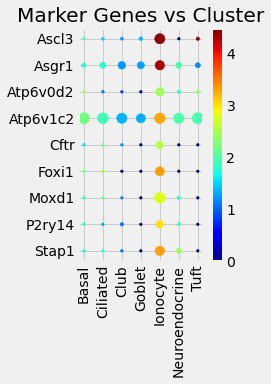

In [47]:
# DON'T CHANGE THIS CODE
# PLOTS THE DOT PLOT
clusters = np.unique(metadata.column("cluster"))
x_axis_ticks = np.arange(0, len(clusters))
genes_uniq = ["Stap1", "P2ry14", "Moxd1", "Foxi1", "Cftr", "Atp6v1c2", "Atp6v0d2", "Asgr1", "Ascl3"]
y_axis_ticks = np.arange(0, len(genes_uniq))
mesh = np.meshgrid(x_axis_ticks, y_axis_ticks)
plots.figure(figsize=(2.5,4))

sizes = np.zeros_like(mesh[0], dtype=float)
colors = np.zeros_like(mesh[0], dtype=float)

for i, c in enumerate(clusters):
    for j, g in enumerate(genes_uniq):
        vals = values(c, g)
        m = vals[0]
        p = vals[1]
        
        sizes[j, i] = p
        colors[j, i] = m


sizes = 7 + (sizes * (120/np.max(sizes)))
plots.scatter(mesh[0], mesh[1], s=sizes, c=colors, cmap="jet");

plots.xticks(x_axis_ticks, clusters, rotation = 90);
plots.yticks(y_axis_ticks, genes_uniq);
plots.colorbar();
plots.title("Marker Genes vs Cluster");

### As you can see, ionocytes are indeed associated with our marker genes, and thus associated with cystic fibrosis. With this knowledge in hand, we can design future experiments to analyze the effects of medicines targeted at this cell type, and work towards treating cystic fibrosis. 

Using table manipulation and visualization skills, I have:
- Analyzed the popularity of a new technology, scRNA-seq, using rolling averages
- Manipulated scRNA-seq data into a usable format
- Identified an association between a novel cell type, ionocytes, and the disease cystic fibrosis, opening the way for future research.